# Temperature extremes

In [1]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import spatial_selection
import plotting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dask.diagnostics.ProgressBar().register()

In [4]:
start_date = '1980-01-01'
end_date = '1989-12-31'

In [5]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

In [6]:
def read_data(infile, regrid=False, time_bounds=None):
    """Read data and calculate annual mean.
    
    Parameters
    ----------
    infile (str)
    regrid (xarray Dataset) - grid to remap to
    time_bounds (list)
    
    """
    
    ds = xr.open_dataset(infile, decode_timedelta=False)
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    annual_mean = ds.mean('time', keep_attrs=True)
    if type(regrid) == xr.core.dataset.Dataset:
        regridder = xe.Regridder(ds, regrid, "bilinear")
        annual_mean = regridder(annual_mean)    
    annual_mean = spatial_selection.select_shapefile_regions(annual_mean, aus_shape)    
    annual_mean = annual_mean.compute()
    
    return annual_mean

In [7]:
def plot_index(var_name, index_name, data_levels, diff_levels):
    """Plot a climate index"""

    index_name_lower = index_name.lower()
    infiles = {}
    infiles['AGCD'] = f'/g/data/xv83/dbi599/indices/{index_name_lower}_year_AGCD_v1_r005_1910-2021.nc'
    infiles['ACCESS-CM2'] = f'/g/data/xv83/dbi599/indices/{index_name_lower}_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc'
    infiles['BARPA'] = f'/g/data/xv83/dbi599/indices/{index_name_lower}_year_BOM-BARPA-R-ACCESS-CM2_historical_r4i1p1f1_1980-1989.nc'

    annual_mean = {}
    annual_mean['AGCD'] = read_data(
        infiles['AGCD'], regrid=False, time_bounds=[start_date, end_date]
    )

    for model in ['ACCESS-CM2', 'BARPA']:
        annual_mean[model] = read_data(
            infiles[model], regrid=annual_mean['AGCD'], time_bounds=[start_date, end_date]
        )

    plotting.compare_agcd_gcm_rcm(
        annual_mean['AGCD'][index_name],
        annual_mean['ACCESS-CM2'][index_name],
        var_name,
        index_name_lower,
        'ACCESS-CM2',
        'BARPA',
        start_date,
        end_date,
        data_levels,
        diff_levels,
        rcm_da=annual_mean['BARPA'][index_name],
)

## TXx - Maximum daily maximum temperature

/g/data/xv83/dbi599/model-evaluation/tasmax_txx_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


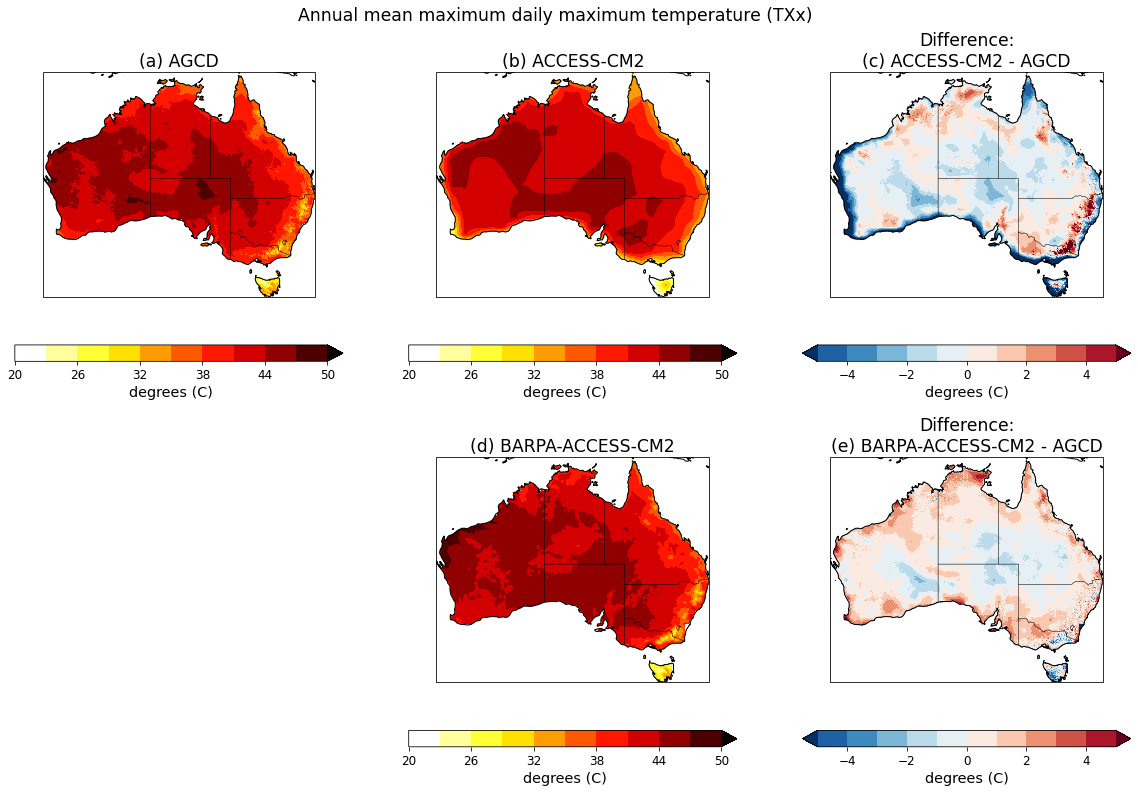

In [12]:
plot_index(
    'tasmax',
    'TXx',
    [20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
)

## TXn - Minimum daily maximum temperature

/g/data/xv83/dbi599/model-evaluation/tasmax_txn_BARPA-ACCESS-CM2_1980-01-01_1989-12-31.png


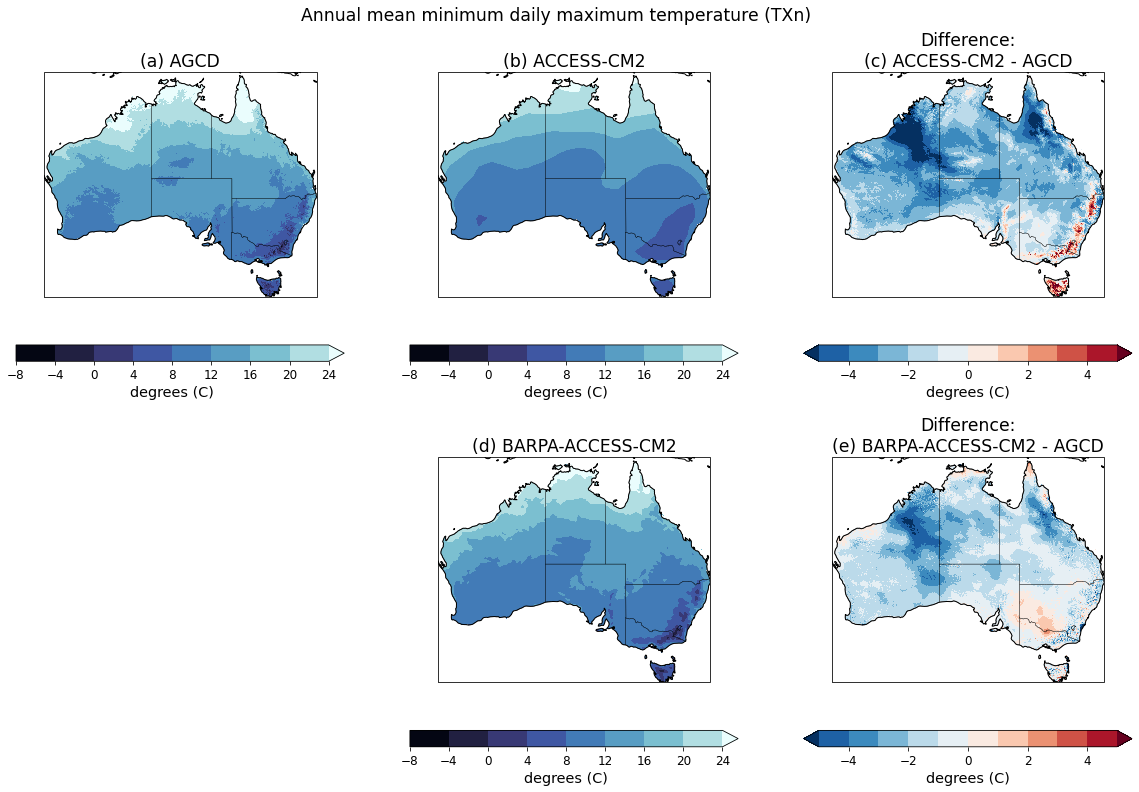

In [13]:
plot_index(
    'tasmax',
    'TXn',
    [-8, -4, 0, 4, 8, 12, 16, 20, 24],
    [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
)

## WSDI - Warm spell duration index

Annual count of days with at least six consecutive days where Tmax > 90th percentile.  
TODO: Submit job

## CSDI - Cold spell duration index

Annual count of days with at least six consecutive days where Tmin < 10th percentile.  
TODO: Submit job